# Perform Kolmogorov-Smirnov Test
In statistics, the Kolmogorov–Smirnov test (K–S test or KS test) is a nonparametric test of the equality of continuous, one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). 

In this notebook we will show you how to perform [one-sample K-S tests using SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) to determine whether data was drawn from a target distribution, and [two-sample K-S tests](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) to determine whether two datasets are drawn from the same distribution.

In [1]:
# import libraries
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, kstest
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# plot within the notebook
%matplotlib inline

# some plotting configurations
matplotlib.rcParams['figure.figsize'] = (16.0, 14.0)
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def declare_significance(p):
    if p<=0.001:
        return('Reject null hypothesis, p<0.001')
    elif p<=0.01:
        return('Reject null hypothesis, p<0.01')
    elif p<=0.05:
        return('Reject null hypothesis, p<0.05')
    else:
        return('Cannot reject null hypothesis')

Let's define a set of distributions from which we will draw i.i.d. samples.

In [3]:
# Distributions from which to generate data, shape constants were taken 
# from the examples on the scipy.stats distribution documentation pages.

DISTRIBUTIONS = [   
    stats.beta(a=2, b=5),
    stats.chi2(df=3, loc=0.0, scale=1.0),
    stats.cosine(loc=0.0, scale=1.0), 
    stats.exponnorm(K=1.5, loc=0.0, scale=1.0),
    stats.exponpow(b=3, loc=0.0, scale=1.0),
    stats.gennorm(beta=1.3, loc=0.0, scale=1.0), 
    stats.gamma(a=1.99, loc=0.0, scale=1.0),
    stats.invgamma(a=4.07, loc=0.0, scale=1.0),
    stats.invgauss(mu=0.15, loc=0.0, scale=1.0), 
    stats.logistic(loc=0.0, scale=1.0), 
    stats.norm(loc=0.0, scale=1.0),
    stats.triang(c=0.158, loc=0.0, scale=1.0), 
    stats.uniform(loc=0.0, scale=1.0), 
]


Null Hypothesis = Samples are drawn from the best-fit normal distribution




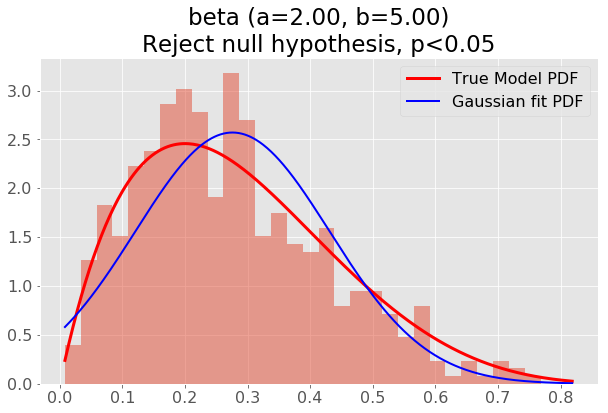

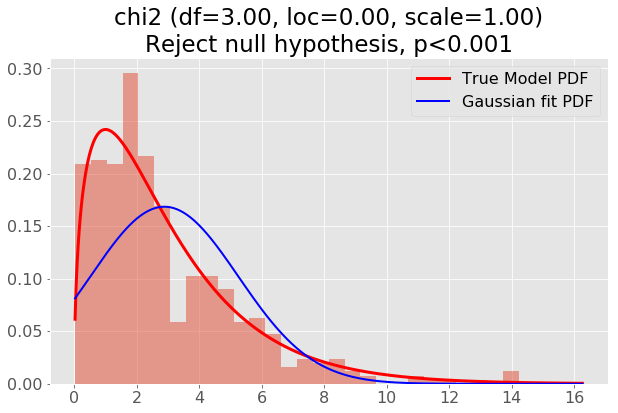

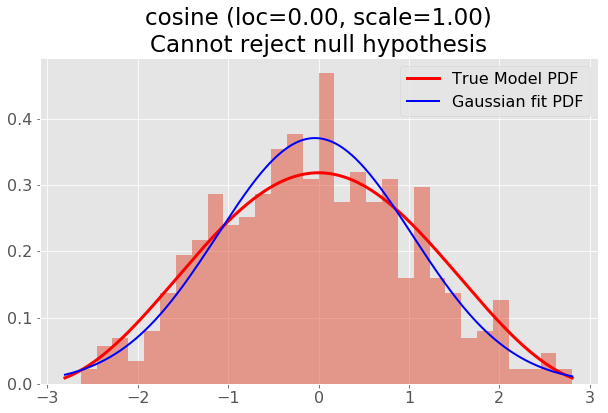

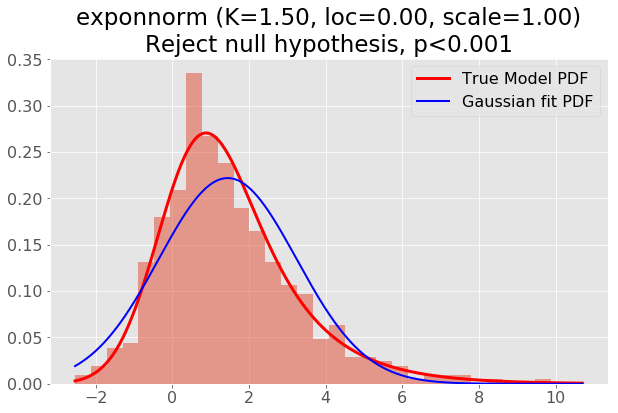

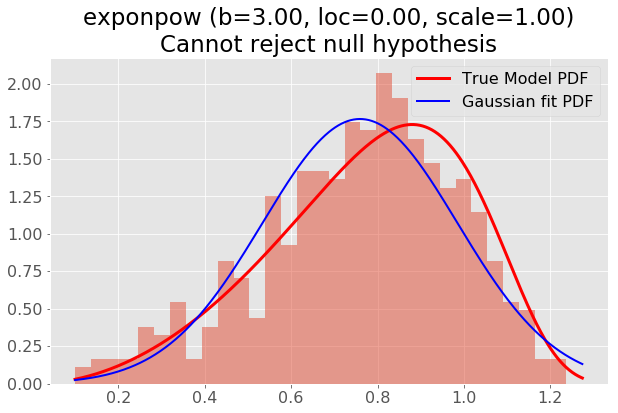

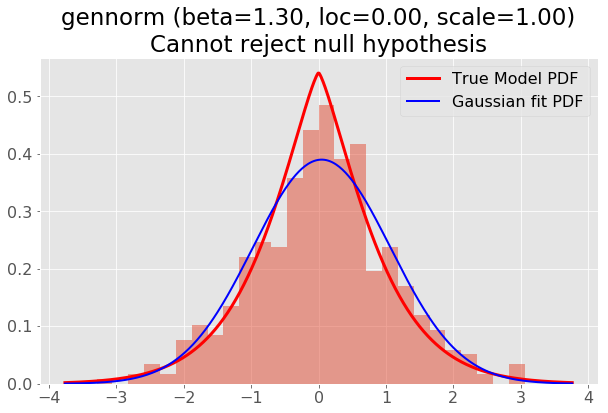

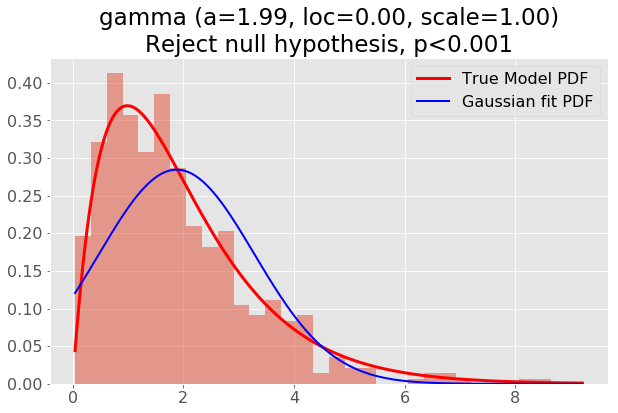

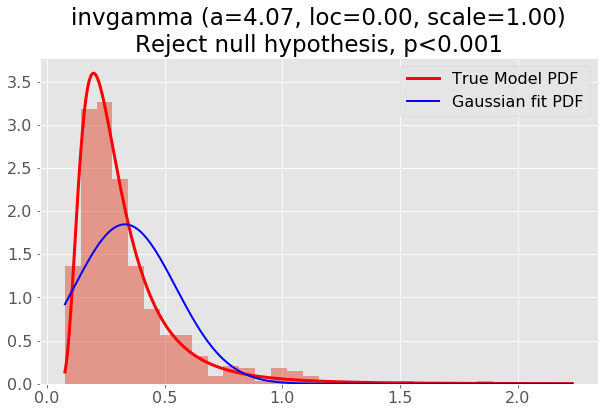

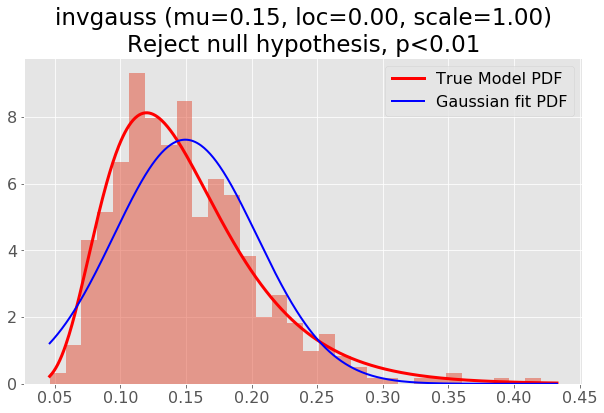

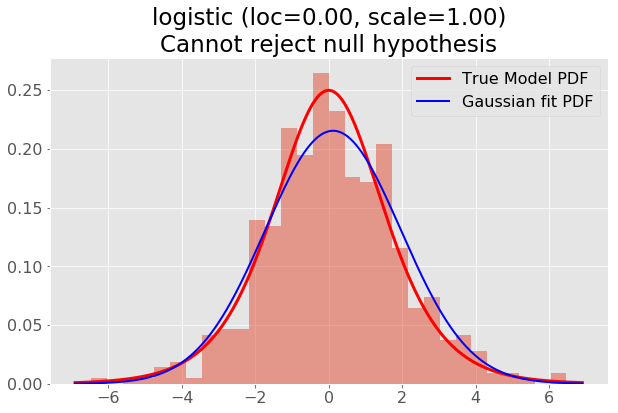

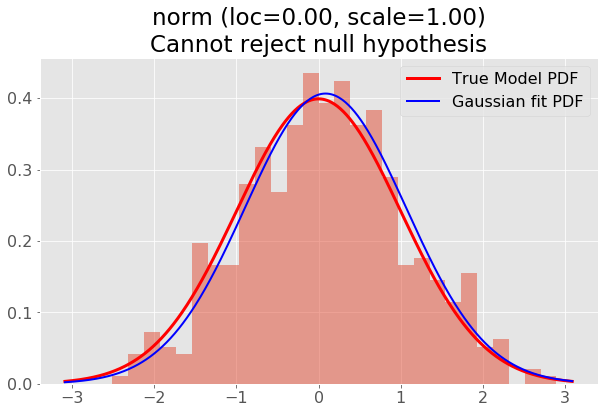

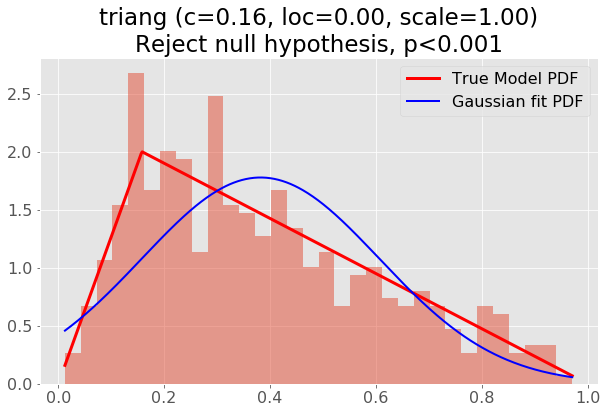

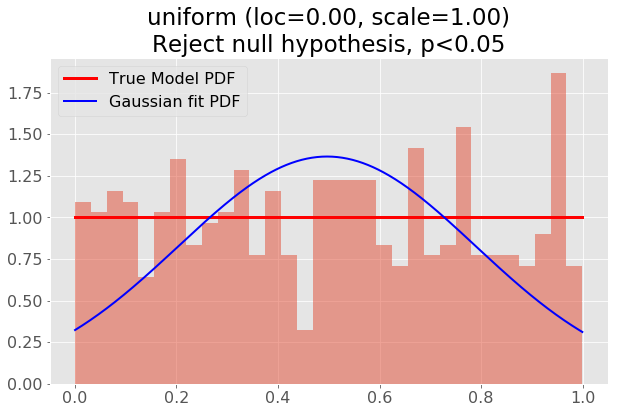

In [4]:
# number of histogram bins
bins = 32

# number of data points 
size = 500

print('\nNull Hypothesis = Samples are drawn from the best-fit normal distribution\n\n')

for distribution in DISTRIBUTIONS:
    try:  
        # Generate i.i.d. data
        rv = pd.Series(distribution.rvs(size=size))
        
        # Get reasonable start and end points of distribution
        start = distribution.ppf(0.001)
        end = distribution.ppf(0.999)

        # Build PDF of the true distribution 
        x = np.linspace(start, end, size)
        y = distribution.pdf(x)
        pdf = pd.Series(y, x)
        
        # Fit a normal distribution to the data
        mu, std = stats.norm.fit(rv)
        ynorm = stats.norm.pdf(x, mu, std)
        pdfnorm = pd.Series(ynorm, x)
        
        # Test whether the data was drawn from the standard normal distribution (null hypothesis)
        d_dist, p_dist = kstest(rv, 'norm', args=(mu,std))

        # Create distribution name and parameter string
        title = '{} ({})\n{}'.format(distribution.dist.name,
                                     ', '.join(['{}={:0.2f}'.format(k,v) for k,v in distribution.kwds.items()]),
                                    declare_significance(p_dist))

        # Plot
        plt.figure(figsize=(10, 6))
        plt.hist(rv,bins=np.linspace(start, end, bins+1),normed=True, alpha=0.5)
        ax = pdf.plot(kind='line', label='True Model PDF', legend=True, lw=3, color='r')
        ax = pdfnorm.plot(kind='line', label='Gaussian fit PDF', legend=True, lw=2, color='b')
        if distribution.dist.name == 'beta' and distribution.kwds['a']==0.5:
            ax.set_ylim([0,4])
        ax.set_title(title)
        plt.show()
        

    except Exception as e:
        print('could not create and/or plot data', distribution.dist.name)
        print(e)

# Perform 2-Sample Kolmogorov-Smirnov Test

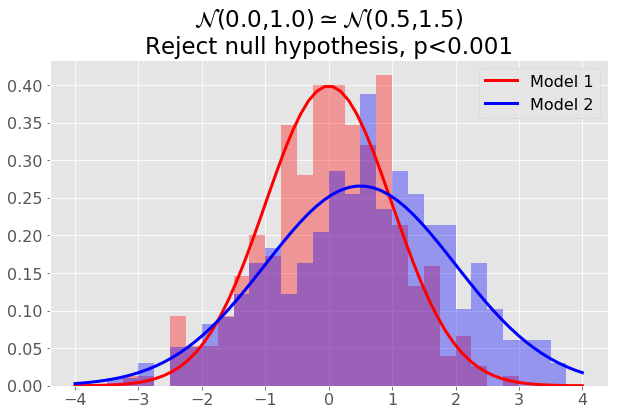

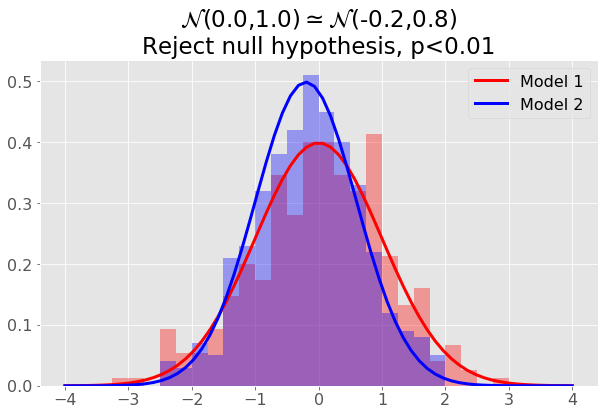

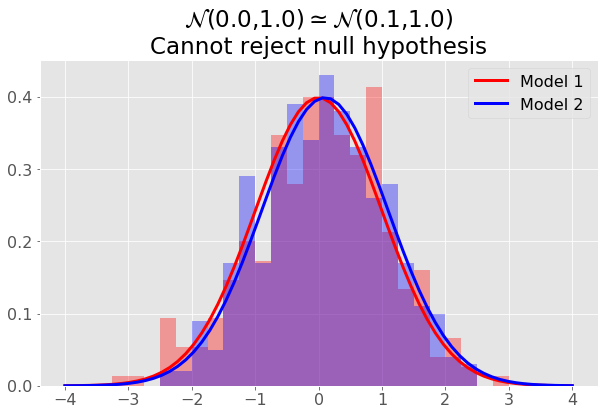

In [17]:
# set histogram parameters
bins = 32
start = -4.0
end = 4.0


#np.random.seed(12345678)  #fix random seed to get the same result each time
n1 = 300  # size of first sample
n2 = 400  # size of second sample



# Set the means and variances of the distributions
rvs1_mean = 0.
rvs1_cov = 1.
rvs2_means = [0.5, -0.2, 0.1]
rvs2_vars = [1.5, 0.8, 1.]

# Generate first distribution
rvs1 = stats.norm.rvs(size=n1, loc=rvs1_mean, scale=rvs1_cov)
norm1str = r'$\mathcal{N}$'+'({:0.1f},{:0.1f})'.format(rvs1_mean,rvs1_cov)

# Build PDF of the first distribution 
x1 = np.linspace(-4,4, 64)
y1 = stats.norm.pdf(x1, loc=rvs1_mean, scale=rvs1_cov)
pdf1 = pd.Series(y1, x1)
        

for loc,scale in zip(rvs2_means,rvs2_vars):
    
    rvs2 = stats.norm.rvs(size=n2, loc=loc, scale=scale)
    norm2str = r'$\mathcal{N}$'+'({:0.1f},{:0.1f})'.format(loc,scale)
    
    # Perform K-S test
    d_dist2, p_dist2 = stats.ks_2samp(rvs1, rvs2)
    
    # Build PDF of the second distribution 
    y2 = stats.norm.pdf(x1, loc=loc, scale=scale)
    pdf2 = pd.Series(y2, x1)
        
    # Plot
    title = norm1str+r'$\simeq$'+norm2str+'\n{}'.format(declare_significance(p_dist2))
    plt.figure(figsize=(10, 6))
    plt.hist(rvs1,bins=np.linspace(start, end, bins+1),normed=True, alpha=0.35, color='r')
    plt.hist(rvs2,bins=np.linspace(start, end, bins+1),normed=True, alpha=0.35, color='b')
    
    ax = pdf1.plot(kind='line', label='Model 1', legend=True, lw=3, color='r')
    ax = pdf2.plot(kind='line', label='Model 2', legend=True, lw=3, color='b')
        
    plt.title(title)
    plt.show()


